## Convolution Neural Network (CNN)
In this notebook we show how to do the classification using a simple CNN. First we load the data and the necessary libraries. As in the previous notebook we could also load the whole data set.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import cPickle as pickle
import gzip
with gzip.open('../data/mnist_4000.pkl.gz', 'rb') as f:
    (X,y) = pickle.load(f)
PIXELS = len(X[0,0,0,:])
X.shape, y.shape, PIXELS

((4000, 1, 28, 28), (4000,), 28)

In [ ]:
#from create_mnist import load_data_2d
#X,y,PIXELS = load_data_2d('/home/dueo/dl-playground/data/mnist.pkl.gz')
#X.shape, y

X contains the images and y contains the labels.

### A first simple CNN
Now let's train a network with using the loaded data. 
#### Definition of the network
We again use the simple definition using the class `NeuralNet` from `nolearn.lasagne`.

In [2]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_ds=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_ds=(2, 2),
    hidden4_num_units=500,
    output_num_units=10, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=10,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

####Training of the net. 
As in the MLP example the data is split automatically into 80% training set and 20% test set. Since it takes quite a while to finish an epoch (at least with a CPU), we reduce the data to 1000 samples (800 for training and 200 for testing). Note also that the geometry makes sense. The first 3x3 convolution knocks off 2 pixels from the 28x28 images resulting in 26x26 images. Then the maxpooling with size 2x2 reduces these images to 13x13 pixels... 

In [3]:
net = net1.fit(X[0:1000,:,:,:],y[0:1000])

  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  DenseLayer        	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    2.227681  |    2.069659  |     1.076352  |     46.16%  |  7.0s
     2  |    1.780428  |    1.514224  |     1.175802  |     58.20%  |  6.9s
     3  |    1.114507  |    0.935836  |     1.190921  |     72.74%  |  6.9s
     4  |    0.671378  |    0.729170  |     0.920743  |     79.69%  |  7.0s
     5  |    0.437301  |    0.702218  |     0.622743  |     78.64%  |  7.0

Note this takes a bit time on a CPU (approx 7 sec) for each epoch. If running on the GPU it onlty takes about 0.2 sec for each epoch.

We have a trained classifier with which we can make predictions.

In [4]:
net.predict(X[3000:3010,:,:,:])

array([9, 0, 9, 8, 1, 3, 2, 5, 7, 4])

**That's basically all we need! ** We can make predictions on new data.
In the following I will show you how to store and reload the learned model. The reloaded model can then be further trained.

##### Storing the trained model
We now store the trained model using the pickle mechanism as follows:

In [6]:
import cPickle as pickle
with open('data/net1.pickle', 'wb') as f:
    pickle.dump(net, f, -1)

In [7]:
%ls -rtlh data

total 24264
-rw-r--r--  1 oli  staff    12M Apr 17 18:18 net1.pickle


#### Loading a stored model
We load the model trained model again...

In [8]:
import cPickle as pickle
with open('data/net1.pickle', 'rb') as f:
    net_pretrain = pickle.load(f)

#### Training further (more iterations)
We can now take the net and train it for further iterations. We will see that the training loss already starts with the low value from the previous model. So the model is really reloaded.

In [9]:
net_pretrain.fit(X[0:1000,:,:,:],y[0:1000]);

  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  DenseLayer        	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.125155  |    0.572778  |     0.218505  |     86.12%  |  7.0s
     2  |    0.121033  |    0.598557  |     0.202208  |     86.12%  |  7.0s
     3  |    0.109925  |    0.566477  |     0.194051  |     87.17%  |  7.0s
     4  |    0.085017  |    0.564484  |     0.150609  |     87.17%  |  6.8s
     5  |    0.067735  |    0.580716  |     0.116640  |     86.51%  |  6.8

#### Training further (new data)
We can train also on new data. Now for 5 epochs...

In [10]:
net_pretrain.max_epochs = 5
net_pretrain.fit(X[1000:2000,:,:,:],y[1000:2000]);

  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  DenseLayer        	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.584422  |    1.238126  |     0.472022  |     78.83%  |  7.1s
     2  |    0.276548  |    0.961179  |     0.287717  |     81.06%  |  7.0s
     3  |    0.209308  |    0.757953  |     0.276149  |     83.18%  |  7.1s
     4  |    0.127634  |    0.738340  |     0.172867  |     85.80%  |  7.3s
     5  |    0.090969  |    0.750479  |     0.121214  |     85.02%  |  7.1

### Evaluate the model
We now make predictions on unseen data. We have trained only on the images 0-1999.

In [11]:
toTest = range(3001,3026)
preds = net1.predict(X[toTest,:,:,:])
preds

array([0, 9, 8, 1, 3, 2, 5, 7, 4, 1, 8, 6, 3, 7, 0, 0, 2, 4, 1, 9, 3, 9, 2,
       0, 5])

Let's look at the correponding images.

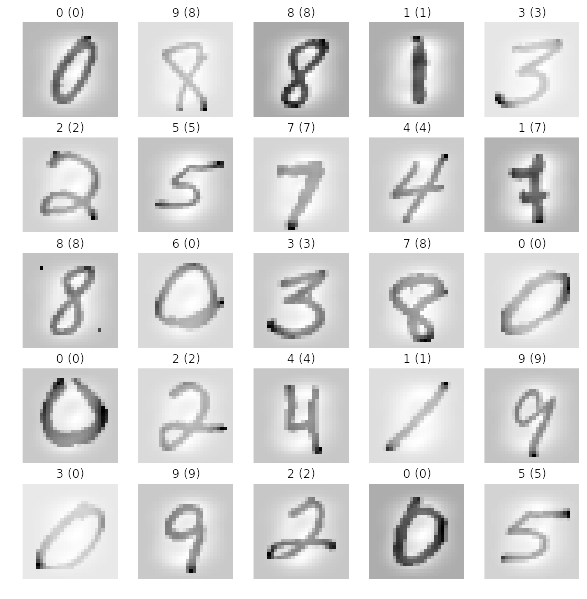

In [12]:
fig = plt.figure(figsize=(10,10))
for i,num in enumerate(toTest):
    a=fig.add_subplot(5,5,(i+1)) #NB the one based API sucks!
    plt.axis('off')
    a.set_title(str(preds[i]) + " (" + str(y[num]) + ")")
    plt.imshow(-X[num,0,:,:], interpolation='none',cmap=plt.get_cmap('gray'))